In [1]:
# ==========================================================
# BLOCCO 1: Confronto Attributi Dataset Zeek
# Controllo e uniformazione colonne tra UWF-ZeekData22 e UWF-ZeekDataFall22
# ==========================================================
import os
import pandas as pd

# ------------- Blocchi 1 e 2: Definizione dei percorsi -------------
# Blocco 1: Cartella ZeekData22
folder_data22 = r"C:\Users\maria\Desktop\Zeek_ML\UWF-ZeekData22"

# Blocco 2: Cartella ZeekDataFall22
folder_datafall22 = r"C:\Users\maria\Desktop\Zeek_ML\UWF-ZeekDataFall22"

# Funzione per caricare tutti i parquet e csv di una cartella in un unico DataFrame
def load_dataset(folder_path):
    all_files = os.listdir(folder_path)
    dfs = []
    for f in all_files:
        path = os.path.join(folder_path, f)
        if f.endswith(".parquet"):
            dfs.append(pd.read_parquet(path))
        elif f.endswith(".csv"):
            dfs.append(pd.read_csv(path))
    if dfs:
        # Concateno tutto in un unico dataframe
        combined_df = pd.concat(dfs, ignore_index=True)
        return combined_df
    else:
        return pd.DataFrame()

# ------------- Blocco 3: Caricamento dataset -------------
df_22 = load_dataset(folder_data22)
df_fall22 = load_dataset(folder_datafall22)

# ------------- Blocco 4: Controllo colonne -------------
cols_22 = set(df_22.columns)
cols_fall22 = set(df_fall22.columns)

# Colonne uniche per ciascun dataset
unique_22 = cols_22 - cols_fall22
unique_fall22 = cols_fall22 - cols_22
common_cols = cols_22 & cols_fall22

# ------------- Blocco 5: Stampa report differenze -------------
print("=== BLOCCO 5: Report differenze tra dataset ===\n")
print(f"Totale colonne in ZeekData22: {len(cols_22)}")
print(f"Totale colonne in ZeekDataFall22: {len(cols_fall22)}\n")

print("Colonne presenti solo in ZeekData22:")
for col in sorted(unique_22):
    print(f"  - {col}")
print("\nColonne presenti solo in ZeekDataFall22:")
for col in sorted(unique_fall22):
    print(f"  - {col}")
print("\nColonne comuni a entrambi i dataset:")
for col in sorted(common_cols):
    print(f"  - {col}")


=== BLOCCO 5: Report differenze tra dataset ===

Totale colonne in ZeekData22: 37
Totale colonne in ZeekDataFall22: 38

Colonne presenti solo in ZeekData22:
  - 2022-01-09 - 2022-01-16
  - 2022-01-16 - 2022-01-23
  - 2022-02-06 - 2022-02-13
  - 2022-02-13 - 2022-02-20
  - dest_ip
  - dest_port
  - mitre_attack_tactics
  - protocol
  - src_ip
  - src_port

Colonne presenti solo in ZeekDataFall22:
  - 2022-08-28 - 2022-09-04
  - 2022-09-04 - 2022-09-11
  - 2022-09-11 - 2022-09-18
  - 2022-09-18 - 2022-09-25
  - 2022-09-25 - 2022-10-02
  - 2022-10-02 - 2022-10-09
  - 2022-10-09 - 2022-10-16
  - 2022-10-16 - 2022-10-23
  - 2022-10-23 - 2022-10-30
  - label_binary
  - label_technique

Colonne comuni a entrambi i dataset:
  - 2021-12-12 - 2021-12-19
  - 2021-12-19 - 2021-12-26
  - 2021-12-26 - 2022-01-02
  - 2022-01-02 - 2022-01-09
  - community_id
  - conn_state
  - datetime
  - dest_ip_zeek
  - dest_port_zeek
  - duration
  - history
  - label_tactic
  - local_orig
  - local_resp
  - misse

In [2]:
# ==========================================================
# BLOCCO 2a–2b: Data Cleaning e Aggregazione (ZeekDataFall22)
# ==========================================================
# Scopo:
# 1. Rimuovere duplicati
# 2. Imputare valori mancanti
# 3. Aggregare per sessione (uid) con feature significative
# ==========================================================

import os
import pandas as pd
import glob
from tqdm import tqdm

# Percorso cartella contenente i file parquet
folder_path = r"C:\Users\maria\Desktop\Zeek_ML\UWF-ZeekDataFall22"
parquet_files = glob.glob(os.path.join(folder_path, "*.parquet"))

# Caricamento dati in un unico DataFrame
dfs = []
for file in tqdm(parquet_files, desc="Caricamento file parquet"):
    dfs.append(pd.read_parquet(file))

data = pd.concat(dfs, ignore_index=True)
print(f"Totale righe prima del cleaning: {len(data)}")
print(f"Totale colonne: {data.shape[1]}")

# ==========================
# 1. Rimozione duplicati
# ==========================
duplicates_before = data.duplicated().sum()
data = data.drop_duplicates()
print(f"Duplicati trovati e rimossi: {duplicates_before}")

# ==========================
# 2. Imputazione valori mancanti
# ==========================
num_cols = data.select_dtypes(include=['int64','float64']).columns
cat_cols = data.select_dtypes(include=['object','category']).columns

imputation_count = 0
for col in num_cols:
    missing = data[col].isna().sum()
    if missing > 0:
        data[col].fillna(data[col].mean(), inplace=True)
        imputation_count += missing

for col in cat_cols:
    missing = data[col].isna().sum()
    if missing > 0:
        data[col].fillna(data[col].mode()[0] if not data[col].mode().empty else 'unknown', inplace=True)
        imputation_count += missing

print(f"Totale valori imputati: {imputation_count}")

# ==========================
# 3. Aggregazioni (session-level features)
# ==========================
print("🧹 Pulizia e aggregazione dati ZeekDataFall22...\n")

if 'uid' not in data.columns:
    print("⚠️ Colonna 'uid' mancante: creata automaticamente come indice numerico sequenziale.")
    data['uid'] = range(len(data))

# Aggregazione per uid
session_features = data.groupby('uid').agg(
    total_orig_bytes=('orig_bytes', 'sum'),
    total_resp_bytes=('resp_bytes', 'sum'),
    total_orig_pkts=('orig_pkts', 'sum'),
    total_resp_pkts=('resp_pkts', 'sum'),
    mean_duration=('duration', 'mean')
).reset_index()

print(f"Totale sessioni aggregate: {session_features.shape[0]}")

# Merge con il dataset originale
data = pd.merge(data, session_features, on='uid', how='left')

print("Prime righe del dataset dopo cleaning e aggregazioni:")
display(data.head())



Caricamento file parquet:   0%|          | 0/13 [00:00<?, ?it/s]

Caricamento file parquet: 100%|██████████| 13/13 [00:01<00:00,  9.59it/s]


Totale righe prima del cleaning: 700340
Totale colonne: 25
Duplicati trovati e rimossi: 16745
Totale valori imputati: 1219118
🧹 Pulizia e aggregazione dati ZeekDataFall22...

Totale sessioni aggregate: 660373
Prime righe del dataset dopo cleaning e aggregazioni:


,community_id,conn_state,duration,history,src_ip_zeek,src_port_zeek,dest_ip_zeek,dest_port_zeek,local_orig,local_resp,...,uid,datetime,label_tactic,label_technique,label_binary,total_orig_bytes,total_resp_bytes,total_orig_pkts,total_resp_pkts,mean_duration
0,1:ktX8uiwrFpzrBHnE1G51yTAiiQo=,S1,41.878964,ShAdD,143.88.10.11,42296,143.88.10.13,9999,False,False,...,CrA3emsiAM5XvugO6,2022-10-23 22:07:45.793,Persistence,T1546,True,44.0,7388.0,28,20,41.878964
1,1:ktX8uiwrFpzrBHnE1G51yTAiiQo=,S1,41.878964,ShAdD,143.88.10.11,42296,143.88.10.13,9999,False,False,...,CrA3emsiAM5XvugO6,2022-10-23 22:07:45.793,Privilege Escalation,Duplicate,Duplicate,44.0,7388.0,28,20,41.878964
2,1:ktX8uiwrFpzrBHnE1G51yTAiiQo=,S1,41.878964,ShAdD,143.88.10.11,42296,143.88.10.13,9999,False,False,...,CrA3emsiAM5XvugO6,2022-10-23 22:07:45.793,Defense Evasion,T1112,True,44.0,7388.0,28,20,41.878964
3,1:ktX8uiwrFpzrBHnE1G51yTAiiQo=,S1,41.878964,ShAdD,143.88.10.11,42296,143.88.10.13,9999,False,False,...,CrA3emsiAM5XvugO6,2022-10-23 22:07:45.793,Persistence,T1547,True,44.0,7388.0,28,20,41.878964
4,1:52yAKDtnHSPDIljwNPlA+UWODdA=,SF,0.041849,ShAdDFaf,143.88.10.11,57042,143.88.10.16,9999,False,False,...,CqO92B3QWHYhyPdtse,2022-10-05 18:14:34.531,Execution,T1059,True,114.0,73.0,9,6,0.041849


⚠️ Campioni benigni rilevati: 350339 / 683595 (51.25%)


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


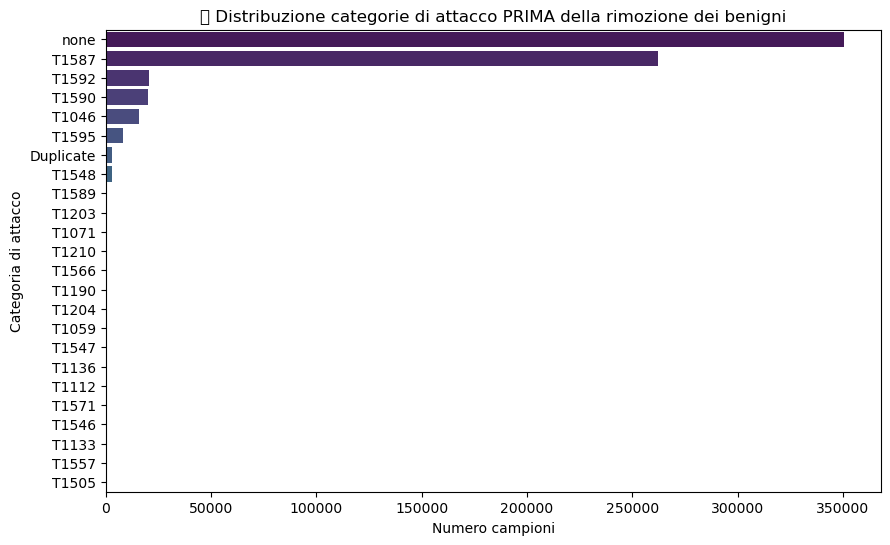

✅ Dopo rimozione benigni: 333256 righe rimanenti.

📊 Distribuzione aggiornata per categorie di attacco (solo attacchi, benigni rimossi):


,Conteggio,Percentuale (%)
label_technique,,
T1587,262409,78.74
T1592,20382,6.12
T1590,20183,6.06
T1046,16025,4.81
T1595,8104,2.43
Duplicate,2899,0.87
T1548,2893,0.87
T1589,278,0.08
T1203,18,0.01


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


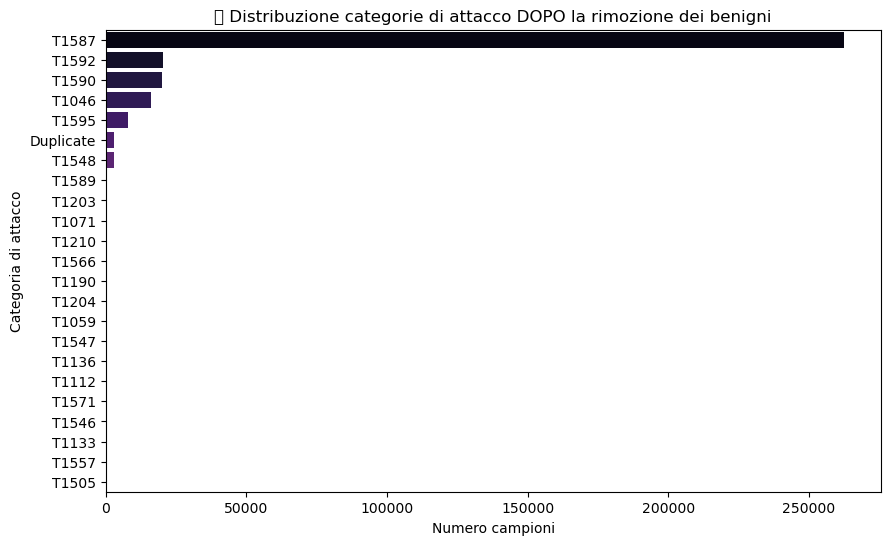

In [3]:
# ==========================================================
# BLOCCO 2c: Rimozione traffico benigno ("none") per multiclasse
# ==========================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Controllo colonna obbligatoria
if 'label_technique' not in data.columns:
    raise KeyError("⚠️ Manca la colonna 'label_technique' nel dataset caricato.")

# ----- Prima della rimozione -----
total_count = len(data)
none_count = (data['label_technique'] == 'none').sum()
print(f"⚠️ Campioni benigni rilevati: {none_count} / {total_count} ({none_count/total_count*100:.2f}%)")

# Grafico prima della rimozione
attack_counts_before = data['label_technique'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(y=attack_counts_before.index, x=attack_counts_before.values, palette='viridis')
plt.title("📊 Distribuzione categorie di attacco PRIMA della rimozione dei benigni")
plt.xlabel("Numero campioni")
plt.ylabel("Categoria di attacco")
plt.show()

# ----- Rimozione benigni -----
data = data[data['label_technique'] != 'none'].reset_index(drop=True)
print(f"✅ Dopo rimozione benigni: {len(data)} righe rimanenti.")

# ----- Dopo la rimozione -----
attack_counts_after = data['label_technique'].value_counts().sort_values(ascending=False)
attack_percent_after = (attack_counts_after / len(data) * 100).round(2)
attack_df_after = pd.DataFrame({
    'Conteggio': attack_counts_after,
    'Percentuale (%)': attack_percent_after
})
print("\n📊 Distribuzione aggiornata per categorie di attacco (solo attacchi, benigni rimossi):")
display(attack_df_after)

plt.figure(figsize=(10,6))
sns.barplot(y=attack_counts_after.index, x=attack_counts_after.values, palette='magma')
plt.title("📊 Distribuzione categorie di attacco DOPO la rimozione dei benigni")
plt.xlabel("Numero campioni")
plt.ylabel("Categoria di attacco")
plt.show()

# ----- Aggiornamento tactic -----
if 'tactic' in data.columns:
    tactic_counts_after = data['tactic'].value_counts().sort_values(ascending=False)
    tactic_percent_after = (tactic_counts_after / len(data) * 100).round(2)
    tactic_df_after = pd.DataFrame({
        'Conteggio': tactic_counts_after,
        'Percentuale (%)': tactic_percent_after
    })
    print("\n📊 Distribuzione aggiornata per tactic (benigni rimossi):")
    display(tactic_df_after)


In [4]:
# ==========================================================
# BLOCCO 3a: Controllo valori nulli e riepilogo colonne/feature
# ==========================================================

# Controllo valori nulli residui
null_counts = data.isna().sum()
null_cols = null_counts[null_counts > 0]

if len(null_cols) == 0:
    print("✅ Non ci sono valori nulli residui.")
else:
    print("⚠️ Colonne con valori nulli residui:")
    display(null_cols)

# Riepilogo colonne e feature rimaste dopo data cleaning e aggregazioni
print("\n📊 Colonne e feature disponibili per l'analisi:")
for i, col in enumerate(data.columns):
    print(f"{i+1}. {col}")

# Opzionale: possiamo separare feature numeriche e categoriali per la fase successiva
num_features = data.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = data.select_dtypes(include=['object','category']).columns.tolist()

print("\n🔹 Feature numeriche:")
print(num_features)
print("\n🔹 Feature categoriali:")
print(cat_features)
# --------------------------
# Salvataggio feature categoriali
# --------------------------
cat_features_df = data[cat_features].copy()
cat_features_df.to_parquet(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\categorical_features.parquet", index=False)
print(f"💾 Feature categoriali salvate: {cat_features_df.shape[1]} colonne, {cat_features_df.shape[0]} righe")


✅ Non ci sono valori nulli residui.

📊 Colonne e feature disponibili per l'analisi:
1. community_id
2. conn_state
3. duration
4. history
5. src_ip_zeek
6. src_port_zeek
7. dest_ip_zeek
8. dest_port_zeek
9. local_orig
10. local_resp
11. missed_bytes
12. orig_bytes
13. orig_ip_bytes
14. orig_pkts
15. proto
16. resp_bytes
17. resp_ip_bytes
18. resp_pkts
19. service
20. ts
21. uid
22. datetime
23. label_tactic
24. label_technique
25. label_binary
26. total_orig_bytes
27. total_resp_bytes
28. total_orig_pkts
29. total_resp_pkts
30. mean_duration

🔹 Feature numeriche:
['duration', 'src_port_zeek', 'dest_port_zeek', 'missed_bytes', 'orig_bytes', 'orig_ip_bytes', 'orig_pkts', 'resp_bytes', 'resp_ip_bytes', 'resp_pkts', 'ts', 'total_orig_bytes', 'total_resp_bytes', 'total_orig_pkts', 'total_resp_pkts', 'mean_duration']

🔹 Feature categoriali:
['community_id', 'conn_state', 'history', 'src_ip_zeek', 'dest_ip_zeek', 'proto', 'service', 'uid', 'label_tactic', 'label_technique', 'label_binary']
💾 F

✅ Feature con varianza significativa: ['ts', 'dest_port_zeek', 'src_port_zeek', 'total_resp_bytes', 'total_orig_bytes', 'resp_ip_bytes', 'orig_ip_bytes', 'resp_bytes', 'orig_bytes', 'total_resp_pkts', 'total_orig_pkts', 'resp_pkts', 'orig_pkts', 'missed_bytes', 'duration', 'mean_duration']
⚠️ Numero di outlier trovati per feature:


ts                  68041
dest_port_zeek          0
src_port_zeek           2
total_resp_bytes    44231
total_orig_bytes    44231
resp_ip_bytes       42325
orig_ip_bytes       68174
resp_bytes          44219
orig_bytes          44219
total_resp_pkts     42325
total_orig_pkts     44073
resp_pkts           42325
orig_pkts           44055
missed_bytes            9
duration            44219
mean_duration       44219
dtype: int64

🏗️ Applicazione trasformazioni per gestire outlier...


📄 REPORT FINALE - Dataset post Winsorization + log

🔹 Statistiche descrittive:


,count,mean,std,min,25%,50%,75%,max
ts,330357.0,2.123221e+01,0.000342,2.123127e+01,2.123236e+01,2.123236e+01,2.123236e+01,2.123236e+01
dest_port_zeek,330357.0,9.134873e+00,2.295414,3.988984e+00,8.685078e+00,1.012162e+01,1.071943e+01,1.107796e+01
src_port_zeek,330357.0,1.079279e+01,0.120515,1.045823e+01,1.069612e+01,1.077304e+01,1.090436e+01,1.100521e+01
total_resp_bytes,330357.0,4.903313e+00,0.559031,4.697642e+00,4.697642e+00,4.697642e+00,4.697642e+00,7.186144e+00
total_orig_bytes,330357.0,4.922246e+00,0.337366,4.819719e+00,4.819719e+00,4.819719e+00,4.819719e+00,6.940222e+00
resp_ip_bytes,330357.0,7.605112e-01,1.990365,9.999995e-07,9.999995e-07,9.999995e-07,9.999995e-07,6.790097e+00
orig_ip_bytes,330357.0,4.022380e+00,0.602113,3.713572e+00,3.806662e+00,3.806662e+00,3.806662e+00,6.748760e+00
resp_bytes,330357.0,4.815831e+00,0.344287,4.697642e+00,4.697642e+00,4.697642e+00,4.697642e+00,6.493754e+00
orig_bytes,330357.0,4.831024e+00,0.214805,4.477337e+00,4.819719e+00,4.819719e+00,4.819719e+00,6.248043e+00
total_resp_pkts,330357.0,2.729620e-01,0.727937,9.999995e-07,9.999995e-07,9.999995e-07,9.999995e-07,3.218876e+00



📝 Motivazione trasformazione:
- Alcune feature avevano outlier estremi che potevano distorcere le distribuzioni.
- Winsorization: limita i valori ai percentili 1% e 99%, riducendo l'impatto degli outlier.
- Log-transform: riduce l'asimmetria e migliora la stabilità numerica.
- Il dataset risultante ha distribuzioni più compatte e valori pronti per scaling/normalizzazione.


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

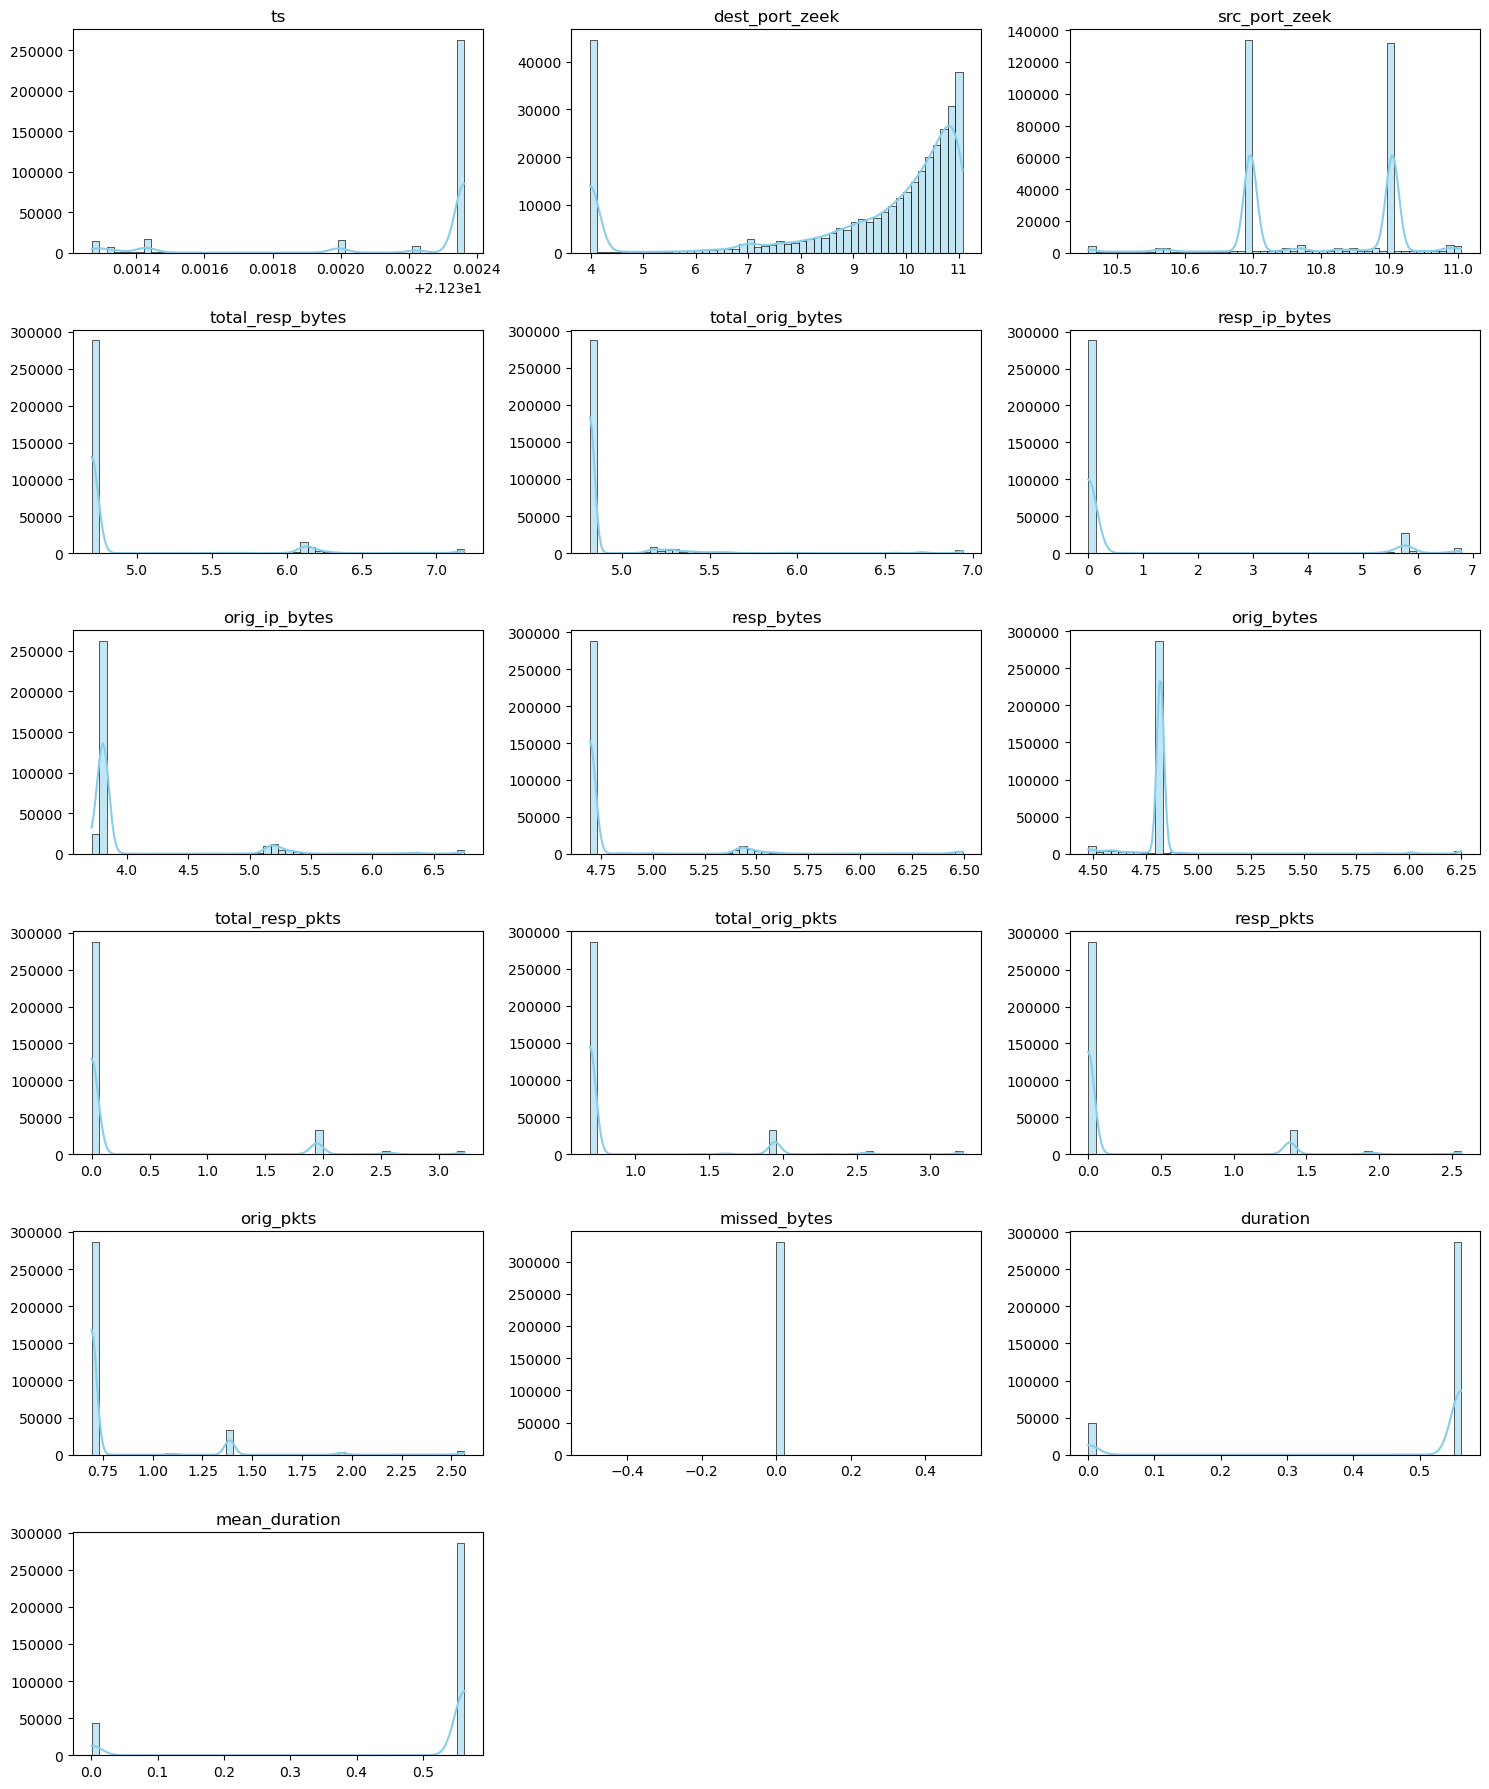

In [5]:
# ==========================================================
# BLOCCO 3b + 3c: Analisi feature numeriche, gestione outlier e trasformazione robusta
# ==========================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

# ================================
# Step 0: Pulizia sicura della label_binary
# ================================
data['label_binary_clean'] = data['label_binary'].map({True:1, False:0, 'True':1, 'False':0, 1:1, 0:0})
data = data.dropna(subset=['label_binary_clean'])
data['label_binary'] = data['label_binary_clean'].astype(int)
data = data.drop(columns=['label_binary_clean'])

# ================================
# Step 1: Selezione feature numeriche
# ================================
num_features = data.select_dtypes(include=['int64','float64']).columns.tolist()
for col in ['label_binary','label_technique','label_tactic']:
    if col in num_features:
        num_features.remove(col)

# ================================
# Step 2: Varianza
# ================================
variance = data[num_features].var().sort_values(ascending=False)
selected_features = variance[variance > 0.01].index.tolist()
print(f"✅ Feature con varianza significativa: {selected_features}")

# ================================
# Step 3: Analisi outlier
# ================================
outlier_summary = {}
for col in selected_features:
    Q1, Q3 = data[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outlier_summary[col] = ((data[col]<lower) | (data[col]>upper)).sum()
print("⚠️ Numero di outlier trovati per feature:")
display(pd.Series(outlier_summary))

# ================================
# Step 4: Trasformazione outlier (Winsorization + log)
# ================================
print("🏗️ Applicazione trasformazioni per gestire outlier...\n")
for col in selected_features:
    lower = data[col].quantile(0.01)
    upper = data[col].quantile(0.99)
    data[col] = np.clip(data[col], lower, upper)
    min_val = data[col].min()
    offset = abs(min_val)+1e-6 if min_val <= 0 else 0
    data[col] = np.log1p(data[col] + offset)
    data[col].replace([np.inf, -np.inf], np.nan, inplace=True)

# 🔧 Fix: rimozione eventuali NaN residui
data = data.dropna(subset=selected_features)

# ================================
# Step 5: Analisi post-transform
# ================================
print("\n📄 REPORT FINALE - Dataset post Winsorization + log\n")
print("🔹 Statistiche descrittive:")
display(data[selected_features].describe().T)

print("\n📝 Motivazione trasformazione:")
print(
    "- Alcune feature avevano outlier estremi che potevano distorcere le distribuzioni.\n"
    "- Winsorization: limita i valori ai percentili 1% e 99%, riducendo l'impatto degli outlier.\n"
    "- Log-transform: riduce l'asimmetria e migliora la stabilità numerica.\n"
    "- Il dataset risultante ha distribuzioni più compatte e valori pronti per scaling/normalizzazione."
)

# ================================
# Step 6: Visualizzazione distribuzioni post-transform
# ================================
cols = 3
rows = math.ceil(len(selected_features)/cols)
plt.figure(figsize=(max(10, cols*5), max(5, rows*3)))
for i, col in enumerate(selected_features, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(data[col].dropna(), bins=50, kde=True, color='skyblue')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()


📊 Analisi bilanciamento classi (binary e multiclass)...

Distribuzione label_binary:
               count  count
label_binary               
1             330357  100.0

Distribuzione label_tactic:
                       count  count
label_tactic                       
Resource Development  262409  79.43
Reconnaissance         48947  14.82
Discovery              16025   4.85
Defense Evasion         2895   0.88
Execution                 29   0.01
Initial Access            18   0.01
Command and Control       14   0.00
Lateral Movement          10   0.00
Persistence                9   0.00
Collection                 1   0.00


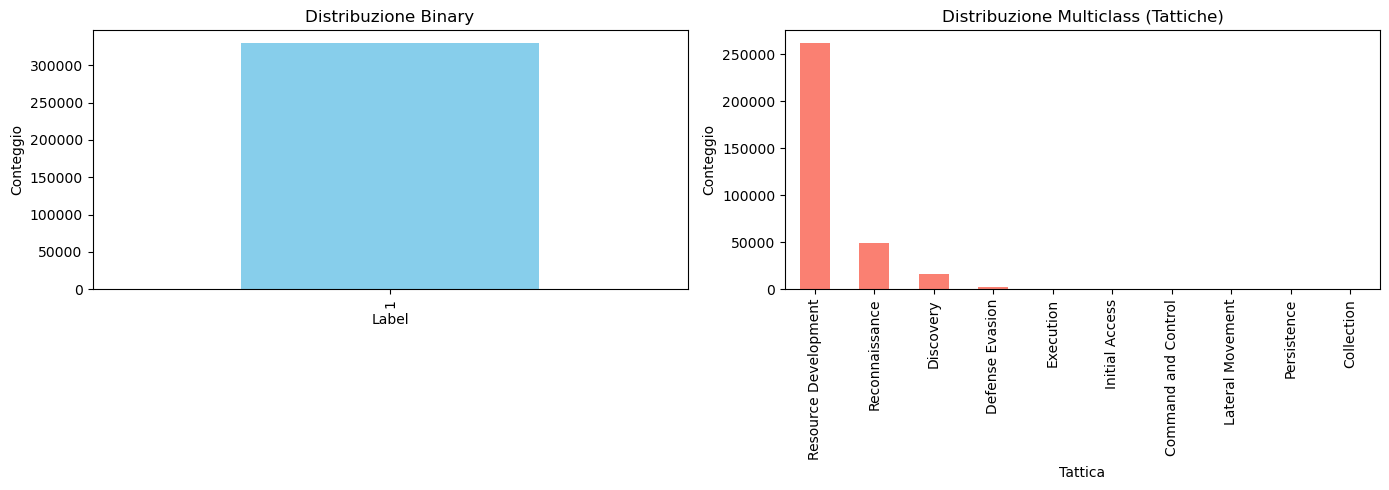

In [6]:
# ==========================================================
# BLOCCO 3d: Analisi bilanciamento delle classi
# ==========================================================
import matplotlib.pyplot as plt

print("📊 Analisi bilanciamento classi (binary e multiclass)...\n")

# Binary
binary_counts = data['label_binary'].value_counts()
binary_perc = binary_counts / binary_counts.sum() * 100
print("Distribuzione label_binary:")
print(pd.concat([binary_counts, binary_perc.round(2)], axis=1).rename(columns={0:'count',1:'%'}))

# Multiclass
multiclass_counts = data['label_tactic'].value_counts()
multiclass_perc = multiclass_counts / multiclass_counts.sum() * 100
print("\nDistribuzione label_tactic:")
print(pd.concat([multiclass_counts, multiclass_perc.round(2)], axis=1).rename(columns={0:'count',1:'%'}))

# Grafici
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
binary_counts.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("Distribuzione Binary")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Conteggio")

multiclass_counts.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title("Distribuzione Multiclass (Tattiche)")
axes[1].set_xlabel("Tattica")
axes[1].set_ylabel("Conteggio")

plt.tight_layout()
plt.show()


📊 Distribuzione classi multiclass ridotte:


,Count,Percent (%)
label_tactic_reduced,,
Resource Development,262409,79.43
Reconnaissance,48947,14.82
Discovery,16025,4.85
Other,2976,0.90


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


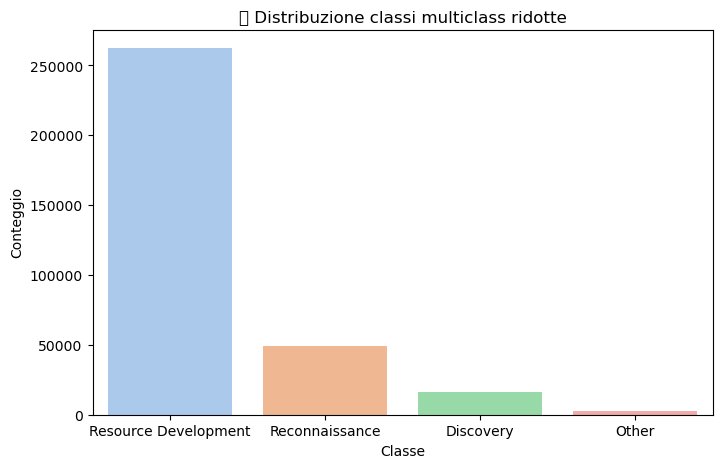

⚖️ Class weights per le classi ridotte:
Other: 27.75
Reconnaissance: 1.69
Resource Development: 0.31
Discovery: 5.15
✅ Class weights salvati in 'model_data/class_weights_dict.pkl'


In [7]:
# ==========================================================
# BLOCCO 3e: Consolidamento classi multiclass rare + class weights
# ==========================================================
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import joblib

# Definizione classi principali
main_classes = ['Resource Development', 'Reconnaissance', 'Discovery']

# Creazione nuova colonna multiclass ridotta
data['label_tactic_reduced'] = data['label_tactic'].apply(
    lambda x: x if x in main_classes else 'Other'
)

# Distribuzione nuove classi
reduced_counts = data['label_tactic_reduced'].value_counts()
reduced_perc = (reduced_counts / reduced_counts.sum() * 100).round(2)
reduced_df = pd.DataFrame({'Count': reduced_counts, 'Percent (%)': reduced_perc})
print("📊 Distribuzione classi multiclass ridotte:")
display(reduced_df)

# Grafico distribuzione
plt.figure(figsize=(8,5))
sns.barplot(x=reduced_counts.index, y=reduced_counts.values, palette='pastel')
plt.title("📊 Distribuzione classi multiclass ridotte")
plt.xlabel("Classe")
plt.ylabel("Conteggio")
plt.show()

# ================================
# Calcolo class weights (utile per training)
# ================================
classes = data['label_tactic_reduced'].unique()
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(classes),
    y=data['label_tactic_reduced']
)
class_weights_dict = dict(zip(classes, class_weights))
print("⚖️ Class weights per le classi ridotte:")
for k,v in class_weights_dict.items():
    print(f"{k}: {v:.2f}")

os.makedirs("model_data", exist_ok=True)
joblib.dump(class_weights_dict, "model_data/class_weights_dict.pkl")
print("✅ Class weights salvati in 'model_data/class_weights_dict.pkl'")

⚖️ Creazione dataset bilanciato tra le tre classi principali...

📊 Distribuzione dopo bilanciamento:
label_tactic_reduced
Resource Development    16025
Reconnaissance          16025
Discovery               16025
Name: count, dtype: int64


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


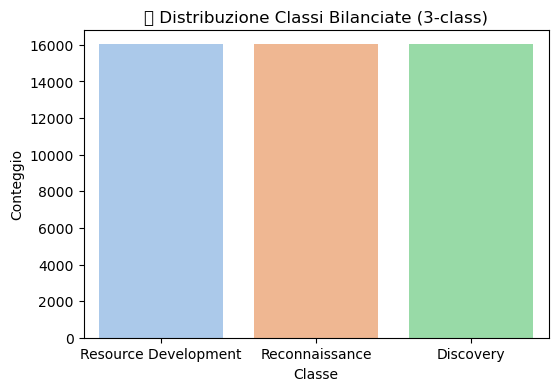

In [8]:
# ==========================================================
# BLOCCO 3f: Creazione dataset bilanciato (3 classi principali)
# ==========================================================
from sklearn.utils import resample

print("⚖️ Creazione dataset bilanciato tra le tre classi principali...\n")

# Filtra solo le 3 classi principali
balanced_data = data[data['label_tactic_reduced'].isin(['Resource Development', 'Reconnaissance', 'Discovery'])]

# Trova la classe più piccola
min_count = balanced_data['label_tactic_reduced'].value_counts().min()

# Esegui sottocampionamento per bilanciare
balanced_samples = []
for cls in ['Resource Development', 'Reconnaissance', 'Discovery']:
    cls_df = balanced_data[balanced_data['label_tactic_reduced'] == cls]
    cls_down = resample(cls_df, replace=False, n_samples=min_count, random_state=42)
    balanced_samples.append(cls_down)

balanced_data = pd.concat(balanced_samples).sample(frac=1, random_state=42).reset_index(drop=True)

# Verifica la nuova distribuzione
print("📊 Distribuzione dopo bilanciamento:")
print(balanced_data['label_tactic_reduced'].value_counts())

plt.figure(figsize=(6,4))
sns.barplot(x=balanced_data['label_tactic_reduced'].value_counts().index,
            y=balanced_data['label_tactic_reduced'].value_counts().values,
            palette='pastel')
plt.title("📊 Distribuzione Classi Bilanciate (3-class)")
plt.xlabel("Classe")
plt.ylabel("Conteggio")
plt.show()


In [9]:
# ==========================================================
# BLOCCO 4: Preparazione dataset per Autoencoder e classificazione
# ==========================================================
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

print("🏗️ Inizio preparazione dataset per autoencoder e classificazione (su dataset bilanciato)...\n")

# ================================
# 1️⃣ Definizione target e dataset di lavoro
# ================================
target_multiclass = 'label_tactic_reduced'

# Controllo che le colonne esistano
required_cols = ['label_binary', 'label_technique', 'label_tactic', target_multiclass]
missing_cols = [c for c in required_cols if c not in balanced_data.columns]
if missing_cols:
    raise KeyError(f"❌ Colonne mancanti nel dataset bilanciato: {missing_cols}")

# Label (multiclasse e binaria)
y_multiclass = balanced_data[target_multiclass].copy()
y_binary = balanced_data['label_binary'].copy()

# ================================
# 2️⃣ Feature set
# ================================
feature_data = balanced_data.drop(columns=['label_binary', 'label_technique', 'label_tactic'])

# ================================
# 3️⃣ Conversione datetime → numerico
# ================================
datetime_cols = feature_data.select_dtypes(include=['datetime64']).columns.tolist()
for col in datetime_cols:
    feature_data[col] = feature_data[col].astype('int64') / 1e9  # secondi Unix

# ================================
# 4️⃣ Frequency Encoding su categoriali
# ================================
cat_features = feature_data.select_dtypes(include=['object', 'category']).columns.tolist()
encoded_data = feature_data.copy()

for col in cat_features:
    freq = encoded_data[col].value_counts(normalize=True)
    encoded_data[col] = encoded_data[col].map(freq)

# ================================
# 5️⃣ Scaling MinMax per l’Autoencoder
# ================================
scaler_auto = MinMaxScaler()
X_autoencoder = pd.DataFrame(
    scaler_auto.fit_transform(encoded_data),
    columns=encoded_data.columns
)

# ================================
# 6️⃣ Output finale e riepilogo
# ================================
print(f"✅ Dataset pronto per l'autoencoder: {X_autoencoder.shape}")
print(f"🔹 Numero di feature totali: {X_autoencoder.shape[1]}")
print(f"🔹 Classi multiclasse bilanciate: {y_multiclass.unique().tolist()}")
print(f"🔹 Classi binarie: {y_binary.unique().tolist()}")

print("\n📊 Distribuzione finale delle classi (bilanciato):")
display(y_multiclass.value_counts())

print("✅ Fine preparazione: X_autoencoder, y_multiclass, y_binary pronti per i modelli.")


🏗️ Inizio preparazione dataset per autoencoder e classificazione (su dataset bilanciato)...

✅ Dataset pronto per l'autoencoder: (48075, 28)
🔹 Numero di feature totali: 28
🔹 Classi multiclasse bilanciate: ['Resource Development', 'Reconnaissance', 'Discovery']
🔹 Classi binarie: [1]

📊 Distribuzione finale delle classi (bilanciato):


label_tactic_reduced
Resource Development    16025
Reconnaissance          16025
Discovery               16025
Name: count, dtype: int64

✅ Fine preparazione: X_autoencoder, y_multiclass, y_binary pronti per i modelli.



🏗️ Inizio costruzione e training dell'Autoencoder...
Epoch 1/40 [------------------------------] loss: 0.015359 | val_loss: 0.002108 | tempo: 6.35s
Epoch 2/40 [━-----------------------------] loss: 0.001477 | val_loss: 0.000944 | tempo: 2.60s
Epoch 3/40 [━━----------------------------] loss: 0.000887 | val_loss: 0.000718 | tempo: 2.48s
Epoch 4/40 [━━━---------------------------] loss: 0.000692 | val_loss: 0.000591 | tempo: 2.36s
Epoch 5/40 [━━━---------------------------] loss: 0.000616 | val_loss: 0.000554 | tempo: 2.36s
Epoch 6/40 [━━━━--------------------------] loss: 0.000577 | val_loss: 0.000539 | tempo: 2.40s
Epoch 7/40 [━━━━━-------------------------] loss: 0.000541 | val_loss: 0.000504 | tempo: 2.16s
Epoch 8/40 [━━━━━━------------------------] loss: 0.000520 | val_loss: 0.000439 | tempo: 2.13s
Epoch 9/40 [━━━━━━------------------------] loss: 0.000500 | val_loss: 0.000455 | tempo: 2.18s
Epoch 10/40 [━━━━━━━-----------------------] loss: 0.000484 | val_loss: 0.000541 | tempo: 2

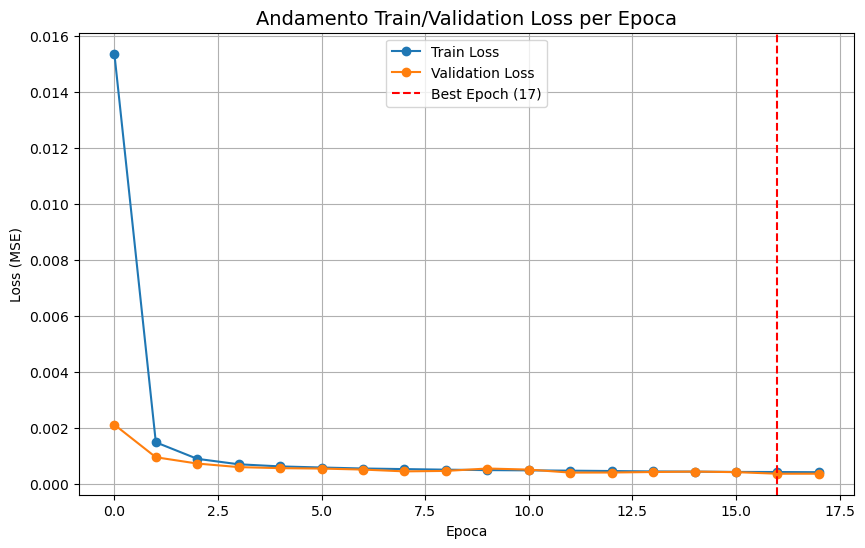

In [10]:
# ==========================================================
# BLOCCO 5: Addestramento Autoencoder con logging avanzato,
# EarlyStopping, salvataggio best epoch e grafico
# ==========================================================
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # riduce warning TF/CUDA

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import time

# Pulizia memoria Keras
tf.keras.backend.clear_session()

print("🏗️ Inizio costruzione e training dell'Autoencoder...")

# 1️⃣ Parametri
input_dim = X_autoencoder.shape[1]
latent_dim = 16

# 2️⃣ Costruzione autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(latent_dim, activation='relu', name='latent_vector')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 3️⃣ EarlyStopping avanzato
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1
)

# 4️⃣ Callback custom per log avanzato
class ProgressLogger(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_logs = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        self.epoch_logs.append({
            'epoch': epoch+1,
            'loss': logs['loss'],
            'val_loss': logs['val_loss'],
            'time_s': elapsed
        })
        bar_len = 30
        progress = int(bar_len * (epoch+1)/self.params['epochs'])
        bar = '━' * progress + '-' * (bar_len - progress)
        print(f"\rEpoch {epoch+1}/{self.params['epochs']} [{bar}] "
              f"loss: {logs['loss']:.6f} | val_loss: {logs['val_loss']:.6f} | tempo: {elapsed:.2f}s", end='\n')

# 5️⃣ Addestramento
logger = ProgressLogger()
history = autoencoder.fit(
    X_autoencoder,
    X_autoencoder,
    epochs=40,
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    verbose=0,
    callbacks=[early_stop, logger]
)

print("\n✅ Autoencoder addestrato con successo.")

# 6️⃣ Recupero best epoch
best_epoch_idx = history.history['val_loss'].index(min(history.history['val_loss']))
best_train_loss = history.history['loss'][best_epoch_idx]
best_val_loss = history.history['val_loss'][best_epoch_idx]
best_time = logger.epoch_logs[best_epoch_idx]['time_s']

print(f"🏆 Best epoch: {best_epoch_idx+1}")
print(f"    Train loss: {best_train_loss:.6f}")
print(f"    Validation loss: {best_val_loss:.6f}")
print(f"    Tempo per epoca: {best_time:.2f}s")

# 7️⃣ Estrazione encoder ottimale
encoder = Model(inputs=input_layer, outputs=autoencoder.get_layer('latent_vector').output)

# 8️⃣ Estrazione embeddings latenti
X_latent = encoder.predict(X_autoencoder)
X_classifier = pd.DataFrame(X_latent, columns=[f'latent_{i}' for i in range(latent_dim)])
y_classifier = y_multiclass.reset_index(drop=True)

# Controllo NaN
assert not y_classifier.isna().any(), "Errore: y_classifier contiene NaN"

print(f"✅ Embeddings generati: {X_classifier.shape}")

# 9️⃣ Grafico Train vs Validation Loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.axvline(x=best_epoch_idx, color='r', linestyle='--', label=f'Best Epoch ({best_epoch_idx+1})')
plt.title("Andamento Train/Validation Loss per Epoca", fontsize=14)
plt.xlabel("Epoca")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


🏗️ Suddivisione dataset in train/test e analisi bilanciamento classi...
✅ Split completato.
Train: (38460, 16), Test: (9615, 16)

📊 Distribuzione classi nel TRAIN:
label_tactic_reduced
Resource Development    33.33
Discovery               33.33
Reconnaissance          33.33
Name: proportion, dtype: float64

📊 Distribuzione classi nel TEST:
label_tactic_reduced
Reconnaissance          33.33
Resource Development    33.33
Discovery               33.33
Name: proportion, dtype: float64


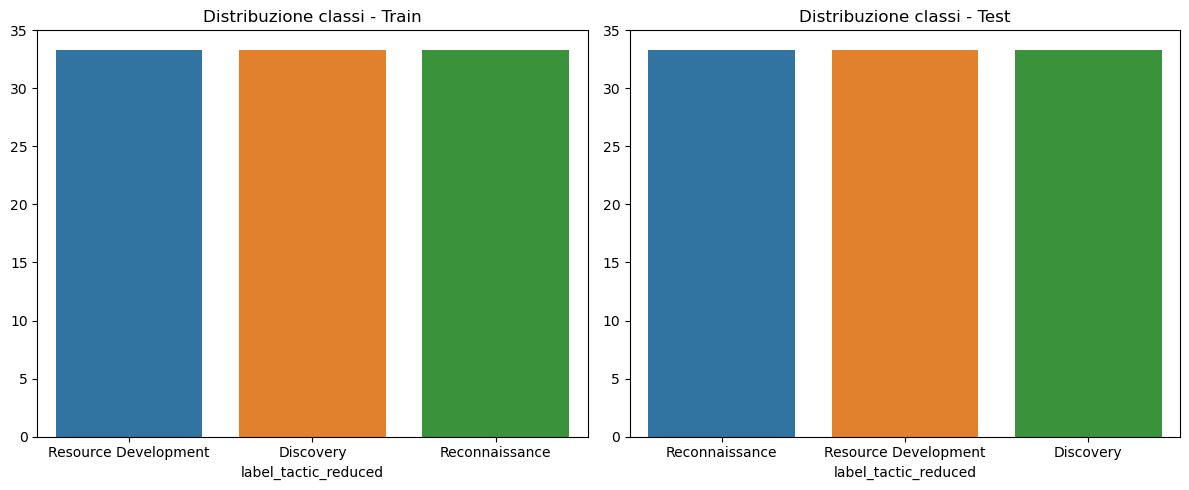


⚙️ Applicazione StandardScaler sugli embeddings latenti...
✅ Scaling completato.


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

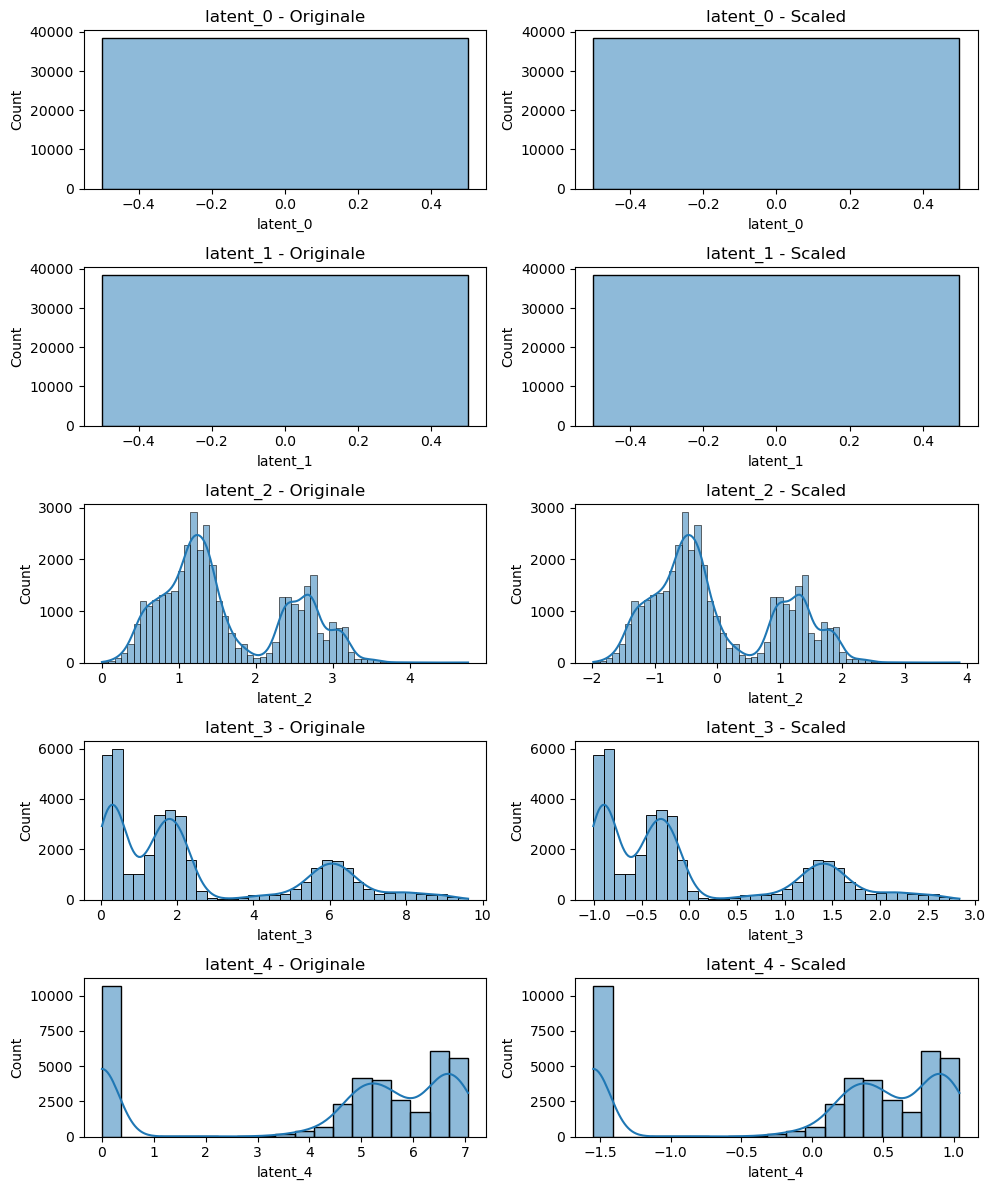


✅ Dataset finale pronto per classificazione multiclasse.
Train: (38460, 16), Test: (9615, 16)


In [11]:
# ==========================================================
# BLOCCO 6: Train/Test Split + StandardScaler + Analisi distribuzioni
# ==========================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

print("🏗️ Suddivisione dataset in train/test e analisi bilanciamento classi...")

# 1️⃣ Split stratificato
X_train, X_test, y_train, y_test = train_test_split(
    X_classifier,
    y_classifier,
    test_size=0.2,
    stratify=y_classifier,
    random_state=42
)

print("✅ Split completato.")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# 2️⃣ Percentuali per categoria
train_dist = y_train.value_counts(normalize=True) * 100
test_dist = y_test.value_counts(normalize=True) * 100

print("\n📊 Distribuzione classi nel TRAIN:")
print(train_dist.round(2))
print("\n📊 Distribuzione classi nel TEST:")
print(test_dist.round(2))

# 3️⃣ Grafico distribuzione classi
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x=train_dist.index, y=train_dist.values, ax=axes[0])
axes[0].set_title("Distribuzione classi - Train")
sns.barplot(x=test_dist.index, y=test_dist.values, ax=axes[1])
axes[1].set_title("Distribuzione classi - Test")
plt.tight_layout()
plt.show()

# 4️⃣ Scaling (solo train, poi test)
print("\n⚙️ Applicazione StandardScaler sugli embeddings latenti...")
scaler_latent = StandardScaler()
X_train_scaled = pd.DataFrame(scaler_latent.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler_latent.transform(X_test), columns=X_test.columns)
print("✅ Scaling completato.")

# 5️⃣ Visualizzazione confronto pre/post scaling su alcune feature
sample_features = X_train.columns[:5]
fig, axes = plt.subplots(len(sample_features), 2, figsize=(10, 12))
for i, feat in enumerate(sample_features):
    sns.histplot(X_train[feat], ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f"{feat} - Originale")
    sns.histplot(X_train_scaled[feat], ax=axes[i, 1], kde=True)
    axes[i, 1].set_title(f"{feat} - Scaled")
plt.tight_layout()
plt.show()

print(f"\n✅ Dataset finale pronto per classificazione multiclasse.")
print(f"Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")


In [12]:
# ==========================================================
# BLOCCO 7: Salvataggio dataset, scaler e encoder
# ==========================================================
import joblib
import os

print("💾 Salvataggio dati e oggetti per training...")

# Crea cartella di output se non esiste
os.makedirs("model_data", exist_ok=True)

# 1️⃣ Salvataggio dataset train/test
X_train_scaled.to_csv("model_data/X_train_balanced.csv", index=False)
X_test_scaled.to_csv("model_data/X_test_balanced.csv", index=False)
y_train.to_csv("model_data/y_train_balanced.csv", index=False)
y_test.to_csv("model_data/y_test_balanced.csv", index=False)

print("✅ Dataset salvati in 'model_data/'")

# 2️⃣ Salvataggio StandardScaler
joblib.dump(scaler_latent, "model_data/scaler_latent.pkl")
print("✅ Scaler salvato come 'scaler_latent.pkl'")

# 3️⃣ Salvataggio encoder
encoder.save("model_data/encoder_best.keras")
print("✅ Encoder salvato come 'encoder_best.keras'")

print("\n🎯 Tutti i dati pronti per l'addestramento dei modelli multiclasse!")


💾 Salvataggio dati e oggetti per training...
✅ Dataset salvati in 'model_data/'
✅ Scaler salvato come 'scaler_latent.pkl'
✅ Encoder salvato come 'encoder_best.keras'

🎯 Tutti i dati pronti per l'addestramento dei modelli multiclasse!
